In [1]:
# STEP 1 : IMPORT NECESSARY TOOLS

import numpy as np 
import pandas as pd 
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# STEP 2 : Directory Setting. Used data of Kaggle (https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset)

p = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(p.glob(r'**/*.png')) #collects all files in sub-directories
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
# os.path.split(os.path.split[0])[1] picks the name of fish

filepaths = pd.Series(filepaths, name = 'FilePaths').astype(str)
Labels = pd.Series(Labels, name = 'Labels').astype(str)

FileLabels = pd.merge(filepaths, Labels, left_index = True, right_index = True)
FileLabels = FileLabels[FileLabels['Labels'].apply(lambda x:x[-2:]!='GT')]
#Remove folders of ground truth images

FileLabels = FileLabels.sample(frac = 1).reset_index(drop = True)
#shuffle the components without replacement

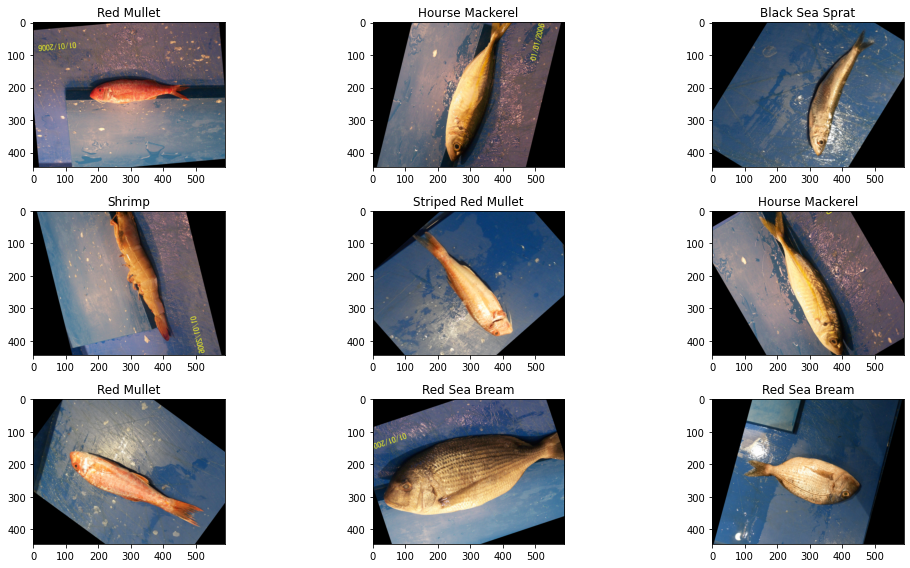

In [3]:
# STEP 3 : Showcase of the images

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8))

for i, a in enumerate(ax.flat):
    a.imshow(plt.imread(FileLabels.FilePaths[i]))
    a.set_title(FileLabels.Labels[i])

plt.tight_layout()
plt.show()

In [4]:
# STEP 4 : How many data we have?

FileLabels['Labels'].value_counts()

Red Mullet            1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Shrimp                1000
Striped Red Mullet    1000
Red Sea Bream         1000
Gilt-Head Bream       1000
Trout                 1000
Sea Bass              1000
Name: Labels, dtype: int64

In [5]:
# STEP 5 : Split train, test, valid data

train_ratio, test_ratio, valid_ratio = 0.7, 0.15, 0.15
x_train, x_test = train_test_split(FileLabels, train_size = train_ratio)
x_val, x_test = train_test_split(x_test, test_size = test_ratio/(test_ratio + valid_ratio))

#shape of x_train, x_test, and x_val
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

img_test = Image.open('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00011.png')
print(img_test.size)
#Figure size

(6300, 2)
(1350, 2)
(1350, 2)
(590, 445)


In [6]:
# STEP 6 : Data Augmentation

AugmentData = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)
#ImageDataGenerator augment the data (e.g., rotation, flip, crop, etc)

image_size = (590, 445)

x_train = AugmentData.flow_from_dataframe(dataframe = x_train, x_col = 'FilePaths', y_col = 'Labels', target_size = image_size, color_mode = 'rgb', class_mode = 'categorical', batch_size = 32, seed = 26)
x_test = AugmentData.flow_from_dataframe(dataframe = x_test, x_col = 'FilePaths', y_col = 'Labels', target_size = image_size, color_mode = 'rgb', class_mode = 'categorical', batch_size = 32, seed = 26)
x_val = AugmentData.flow_from_dataframe(dataframe = x_val, x_col = 'FilePaths', y_col = 'Labels', target_size = image_size, color_mode = 'rgb', class_mode = 'categorical', batch_size = 32, seed = 26)

Found 6300 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


In [7]:
# STEP 7 : Model Construction

model = Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1/255))
model.add(keras.layers.Flatten(input_shape = image_size))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(9, activation = 'softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

model_fit = model.fit(x_train, validation_data = x_val, epochs = 30, callbacks=Callback)

2022-11-08 17:31:33.299963: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-08 17:31:36.112632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
197/197 [==============================] - 288s 1s/step - loss: 1.6818 - accuracy: 0.3959 - val_loss: 1.1406 - val_accuracy: 0.5867
Epoch 2/30
197/197 [==============================] - 205s 1s/step - loss: 1.2288 - accuracy: 0.5622 - val_loss: 0.9575 - val_accuracy: 0.6667
Epoch 3/30
197/197 [==============================] - 205s 1s/step - loss: 1.0005 - accuracy: 0.6470 - val_loss: 0.6823 - val_accuracy: 0.7948
Epoch 4/30
197/197 [==============================] - 203s 1s/step - loss: 0.8212 - accuracy: 0.7144 - val_loss: 0.6117 - val_accuracy: 0.8200
Epoch 5/30
197/197 [==============================] - 202s 1s/step - loss: 0.7398 - accuracy: 0.7414 - val_loss: 0.5223 - val_accuracy: 0.8363
Epoch 6/30
197/197 [==============================] - 208s 1s/step - loss: 0.6349 - accuracy: 0.7771 - val_loss: 0.4981 - val_accuracy: 0.8474
Epoch 7/30
197/197 [==============================] - 208s 1s/step - loss: 0.5328 - accuracy: 0.8105 - val_loss: 0.4201 - val_accuracy: 0.8674

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               100819328 
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [9]:
test_accuracy = model.evaluate(x_test)[1] * 100
print(test_accuracy)

43/43 [==============================] - 42s 992ms/step - loss: 0.2585 - accuracy: 0.9244
92.44444370269775
